# 3D reconstruction
---

In [112]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units

from p3droslo.utils       import convert_angular_to_spatial, get_molar_mass
from p3droslo.object      import AstroObject
from p3droslo.observation import DataCube

from p3droslo.model import TensorModel
from p3droslo.utils import interpolate

In [113]:
import magritte.tools as tools

In [114]:
obj = AstroObject('IK Tau')

Using the parallax distance.


In [115]:
file = '/STER/frederikd/Deprojection/data/observations/IKTau_CO3-2.fits'
dat  = DataCube(file)

In [121]:
dat.img.shape

(61, 256, 256)

In [129]:
from ipywidgets import interact


xx = 131
yy = 133

def plot(f):
    plt.figure(dpi=150)
    plt.imshow(dat.img[f,:,:],
               origin = 'lower',
               # extent = [dat.xs[0].value, dat.xs[-1].value,
                         # dat.ys[0].value, dat.ys[-1].value ]
              )
    plt.scatter([xx], [yy], c='k', marker='x')
interact(plot, f=(0,len(dat.img)-1))

interactive(children=(IntSlider(value=30, description='f', max=60), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [132]:
print(xx / 2)
print(yy / 2)

65.5
66.5


In [133]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=30, description='f', max=60), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [134]:
angle_x = abs(dat.npix_x * dat.pixsize_x)
angle_y = abs(dat.npix_y * dat.pixsize_y)

size_x = 1.0 * units.m #convert_angular_to_spatial(angle_x, obj.distance)
size_y = 1.0 * units.m #convert_angular_to_spatial(angle_y, obj.distance)
size_z = max(size_x, size_y)

size_x = size_x.to(units.m).value
size_y = size_y.to(units.m).value
size_z = size_z.to(units.m).value

box_shape = (128, 128, 128)

In [135]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim      import Adam, LBFGS

In [136]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [137]:
model = TensorModel(
    var_keys  = ['emissivity','opacity'],
    box_sizes = (size_x, size_y, size_z),
    box_shape = box_shape
)

In [138]:
obs = dat.img.astype(np.float64)
fqs = dat.fs .astype(np.float64)

obs = obs[15:48]
fqs = fqs[15:48]

obs = torch.from_numpy(obs)
fqs = torch.from_numpy(fqs)

# Move channel index to last place
obs = obs.transpose(0,1).transpose(1,2)

# Interpolate images to box shape
obs = interpolate(obs, size=(box_shape[0], box_shape[1], obs.size(2)), mode='trilinear')

In [148]:
from ipywidgets import interact

def plot(i):    
    xx = 65
    yy = 66

    plt.figure(dpi=150)
    plt.imshow(obs[:,:,i], vmin=obs.min(), vmax=obs.max())
    plt.scatter([xx], [yy], c='k', marker='x')    
    
interact(plot, i=(0, obs.shape[2]-1))

interactive(children=(IntSlider(value=16, description='i', max=32), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(i)>

In [20]:
model = TensorModel(
    var_keys  = ['emissivity','opacity'],
    box_sizes = (size_x, size_y, size_z),
    box_shape = box_shape
)

# model['opacity'].data *= 1.0e-10

In [21]:
model = TensorModel(
    var_keys  = ['CO', 'temperature', 'velocity_z'],
    box_sizes = (size_x, size_y, size_z),
    box_shape = box_shape
)

v_turb = 5.0e+3 # m/s

In [22]:
def doppler_shift(velo):
    return 1.0 + velo/CC

In [23]:
from p3droslo.lines import LineData

In [82]:
def print_var(name, var):
    print(f"{name} {var.min().item():+1.2e} {var.mean().item():+1.2e} {var.max().item():+1.2e}")

In [83]:
import torch
import numpy as np

from astropy import constants


# Constants
CC  = constants.c  .si.value   # Speed of light [m/s]
HH  = constants.h  .si.value   # Planck's constant [J s]
KB  = constants.k_B.si.value   # Boltzmann's constant [J/K]
AMU = constants.u  .si.value   # Atomic mass unit [kg]


class Line:
    
    def __init__(self, species_name, transition, database='LAMDA', datafile=None):
        """
        Constructor for a line object.
        """
        # Store the name of the species
        self.species_name = species_name
        # Determine the molar mass of the species
        self.species_molar_mass = get_molar_mass(self.species_name)
        # Store the transition number
        self.transition = transition
        # Extract the line data
        self.linedata = LineData(database=database, datafile=datafile, species_name=species_name.lower())
        
        self.upper       = self.linedata.upper       [self.transition]
        self.lower       = self.linedata.lower       [self.transition]
        self.frequency   = self.linedata.frequency   [self.transition]
        self.Einstein_A  = self.linedata.Einstein_A  [self.transition]
        self.Einstein_Bs = self.linedata.Einstein_Bs [self.transition]
        self.Einstein_Ba = self.linedata.Einstein_Ba [self.transition]
        
        self.J_upper = self.linedata.J[self.upper]
        self.J_lower = self.linedata.J[self.lower]
        
        self.energy = torch.from_numpy(self.linedata.energy)
        self.weight = torch.from_numpy(self.linedata.weight)
        
        print(f"You have selected line:")
        print(f"    {self.species_name}(J={self.J_upper}-{self.J_lower})")
        print(f"Please check the properties that were inferred:")
        print(f"    {'Frequency '       :<17} {self.frequency :0.9e}  Hz")
        print(f"    {'Einstein A coeff ':<17} {self.Einstein_A:0.9e}  1/s")
        print(f"    {'Molar mass'       :<17} {self.species_molar_mass:<15}  g/mol")
        
        
    def gaussian_width(self, temperature, v_turbulence):
        """
        Gaussian spectral line width.
        """
        # Compute convenience variables
        factor_1 = self.frequency / CC
        factor_2 = 2.0 * KB / (self.species_molar_mass * AMU)
        # Return the gaussian line width
        return factor_1 * torch.sqrt(factor_2*temperature + v_turbulence**2)


    def gaussian_profile(self, temperature, v_turbulence, freq):
        """
        Gaussian spectral line profile function.
        """
        # Compute convenience variables
        inverse_width = 1.0 / self.gaussian_width(temperature, v_turbulence)
        factor        = 1.0 / np.sqrt(np.pi)
        # Mind the cellwise products
        shift  = torch.einsum("ijk, ijkf -> ijkf",          inverse_width, freq-self.frequency)
        result = torch.einsum("ijk, ijkf -> ijkf", factor * inverse_width, torch.exp(-shift**2))
        # Return the gaussian line profile
        return result

    
    def LTE_pops (self, temperature):
        '''
        Returns the LTE level populations give a temperature.
    
        Parameters
        ----------
        temperature : float
            Temperature for which to evaluate the LTE level populations.
    
        Returns
        -------
        out : array_like
            Array containing the LTE level populations for the given temperature.
        '''
        exponent = torch.einsum("i   ,  jkl -> ijkl", -self.energy/KB, 1.0/temperature) 
        pop      = torch.einsum("i   , ijkl -> ijkl", self.weight, torch.exp(exponent))
        pop      = torch.einsum("ijkl,  jkl -> ijkl", pop, 1.0/torch.sum(pop, dim=0))
        # Return result
        return pop
    
    
    def LTE_emissivity_and_opacity(self, temperature):
        """
        Line emissivity assuming Local Thermodynamic Equilibrium.
        """
        # Compute the prefactor
        factor = HH * self.frequency / (4.0 * np.pi)
        # factor = self.frequency * 1.0e-9
        
        # Compute the LTE level populations
        pop = self.LTE_pops(temperature)
        
        # Compute the emissivity and opacity
        eta = factor *  self.Einstein_A  * pop[self.upper]
        chi = factor * (self.Einstein_Ba * pop[self.lower] - self.Einstein_Bs * pop[self.upper]) 
        
        # print_var("factor", factor)
        # print_var("pop   ", pop)
        
        # Return results
        return (eta, chi)

In [84]:
line = Line('CO', 2)

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


In [85]:
T    = 109.0
temp = T * torch.ones((1,1,1), dtype=torch.float64)

In [86]:
tools.planck(T, line.frequency)

3.707296959485041e-15

In [87]:
eta, chi = line.LTE_emissivity_and_opacity(temp)
print(eta)
print(chi)
(eta/chi).item()

tensor([[[5.9127e-30]]], dtype=torch.float64)
tensor([[[1.5949e-15]]], dtype=torch.float64)


3.707270603222523e-15

In [88]:
def imaging_pipeline(model):
    
    # Compute the Doppler shift for each cell
    shift = 1.0 + model["velocity_z"]/CC
    
    # Create freqency tensor for each cell
    freqs = torch.einsum("ijk, f -> ijkf", shift, fqs)

    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(model['temperature'])
    profile  = line.gaussian_profile          (model['temperature'], v_turb, freqs)

    print_var("eta", eta)
    print_var("chi", chi)
    print_var("pro", profile)
    
    eta = torch.einsum("ijk, ijkf -> ijkf", eta*model['CO'], profile)
    chi = torch.einsum("ijk, ijkf -> ijkf", chi*model['CO'], profile)
    
    # Create an image of the line
    img = model.create_image(eta, chi, axis=2)
    
    # Convolve with beam
    # img = convolve_with_beam(img)
    
    # Resolved out flux
    # img = resolved_out_flux(img)

    # Return the image
    return img

In [89]:
from torch.nn import functional

# def loss_function():
    # return functional.mse_loss(img, obs[0])

In [151]:
centre = (65,66,64)

x, y, z = np.indices(model.box_shape)

x = x - centre[0]
y = y - centre[1]
z = z - centre[2]

In [152]:
plot_slice(torch.Tensor(x))

interactive(children=(IntSlider(value=63, description='i', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.plot_slice.<locals>.plot(i)>

In [93]:
model = TensorModel(
    var_keys  = ['log_CO', 'velocity_z'], #['CO', 'temperature', 'velocity_z'],
    box_sizes = (size_x, size_y, size_z),
    box_shape = box_shape
)

v_turb = 1.5e+3 # m/s

model['temperature'] = 200 * torch.ones_like(model['log_CO'])
# model['velocity_z' ] =   0 * torch.ones_like(model['log_CO'])

# model['temperature'].data *= 250
model['velocity_z' ].data -= 0.5
model['velocity_z' ].data *= 2000.0

# model['CO'         ].data *= 

In [94]:
N_epochs = 10
lr       = 1.0e+1

optimizer = Adam(model.parameters(), lr=lr)

  0%|                                                                                                                            | 0/10 [00:00<?, ?it/s]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 10%|███████████▌                                                                                                        | 1/10 [00:01<00:15,  1.76s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 20%|███████████████████████▏                                                                                            | 2/10 [00:03<00:13,  1.72s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 30%|██████████████████████████████████▊                                                                                 | 3/10 [00:05<00:11,  1.70s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 40%|██████████████████████████████████████████████▍                                                                     | 4/10 [00:06<00:10,  1.71s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 50%|██████████████████████████████████████████████████████████                                                          | 5/10 [00:08<00:08,  1.71s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 60%|█████████████████████████████████████████████████████████████████████▌                                              | 6/10 [00:10<00:06,  1.71s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 7/10 [00:11<00:05,  1.71s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8/10 [00:13<00:03,  1.72s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9/10 [00:15<00:01,  1.73s/it]

eta +0.00e+00 +3.27e-08 +2.09e-05
chi +0.00e+00 +4.64e-10 +2.96e-07
img +0.00e+00 +3.27e-08 +2.10e-06
obs -1.08e-01 +1.30e-02 +8.12e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


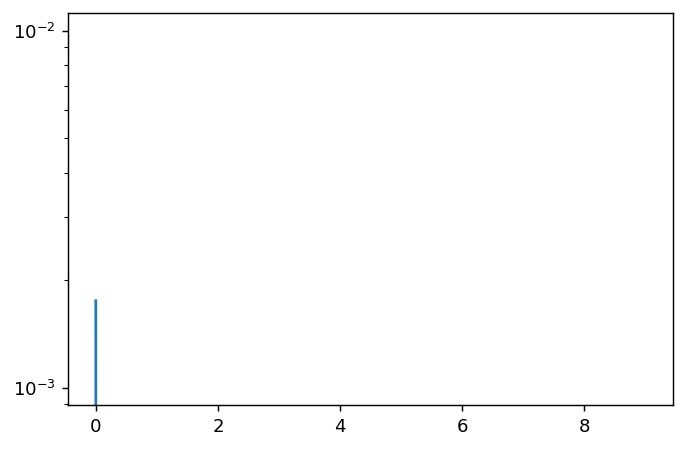

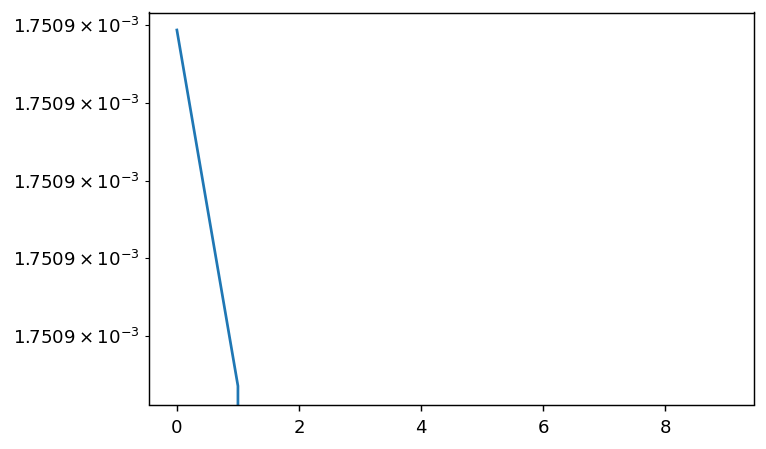

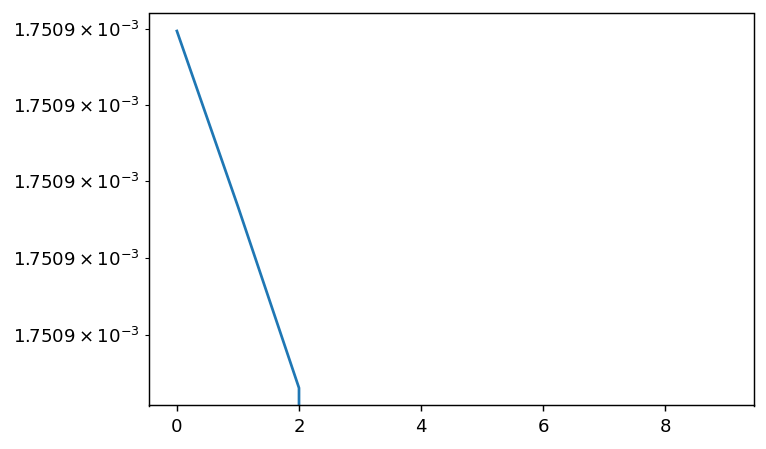

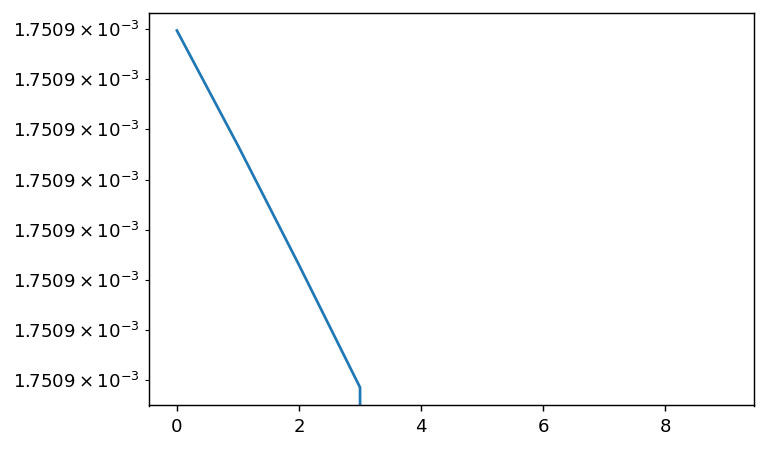

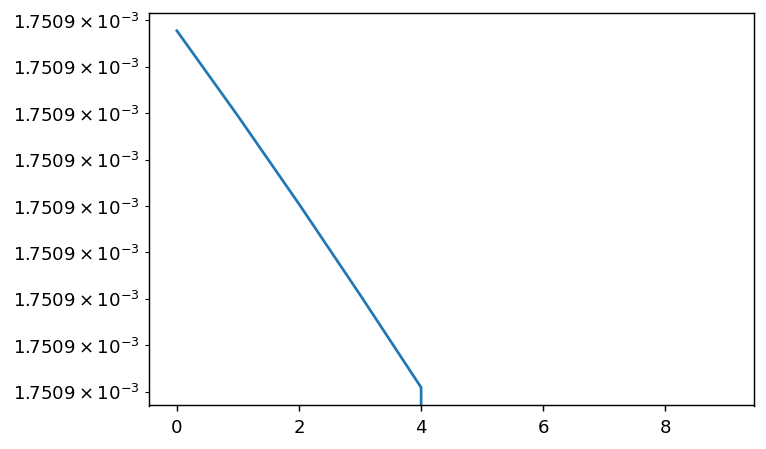

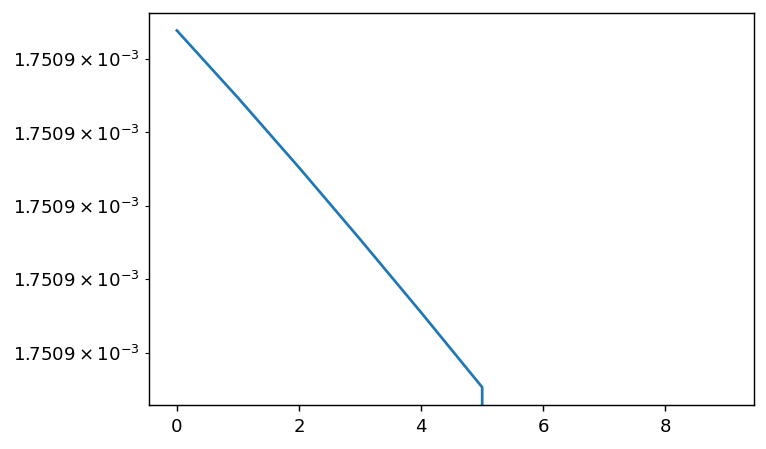

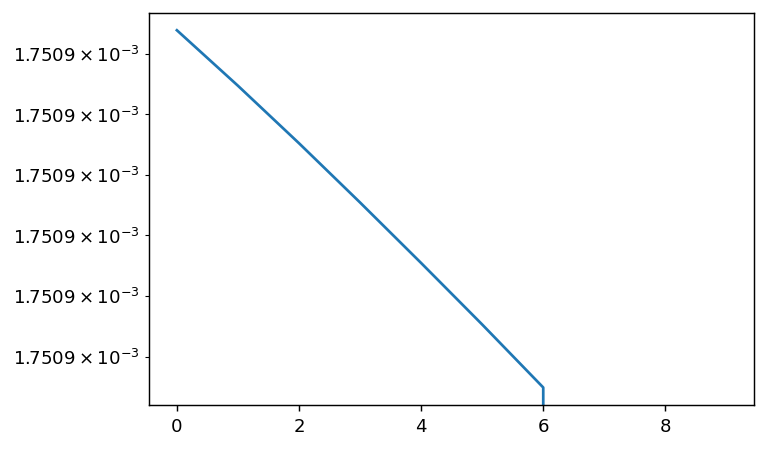

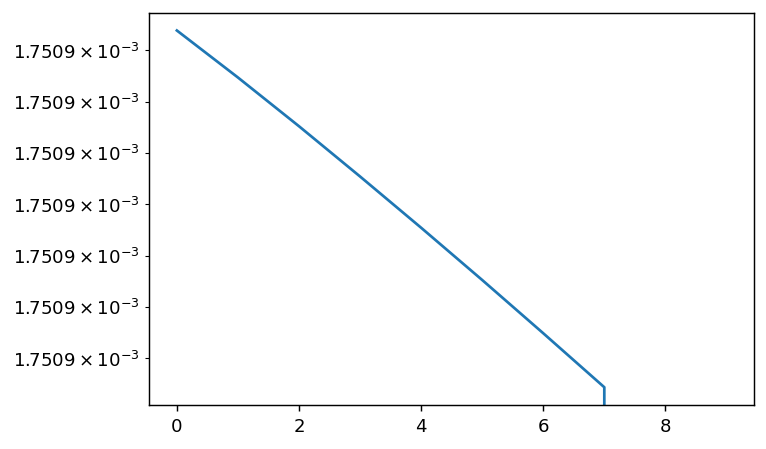

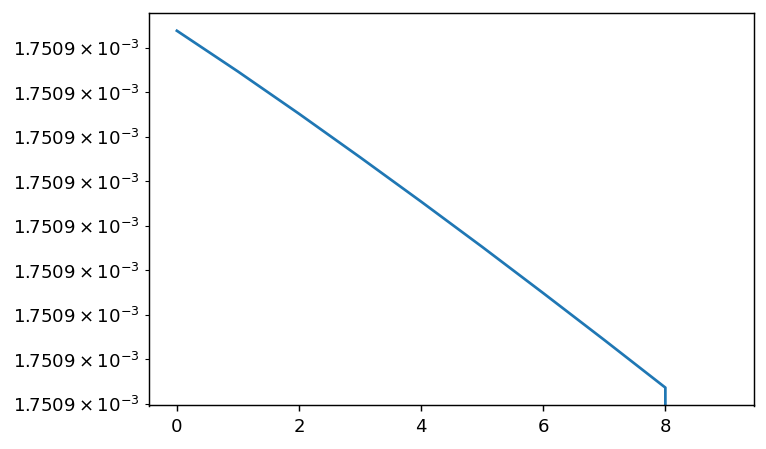

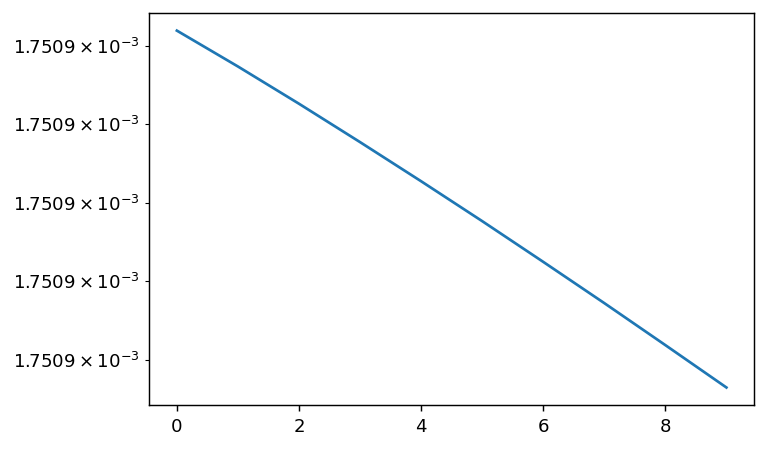

In [97]:
losses = np.zeros(N_epochs)

for i in tqdm(range(N_epochs)):
    
    # img = imaging_pipeline(model)
    
    
    # Compute the Doppler shift for each cell
    shift = 1.0 + model["velocity_z"]/CC
    
    # Create freqency tensor for each cell
    freqs = torch.einsum("ijk, f -> ijkf", shift, fqs)

    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(model['temperature'])
    profile  = line.gaussian_profile          (model['temperature'], v_turb, freqs)

    # print_var("eta", eta)
    # print_var("chi", chi)
    # print_var("pro", profile)
    
    abn = torch.exp(model['log_CO'])
    
    eta = torch.einsum("ijk, ijkf -> ijkf", eta*abn, profile)
    chi = torch.einsum("ijk, ijkf -> ijkf", chi*abn, profile)
    
    eta *= 1.0e+40
    chi *= 1.0e+24
    
    print_var("eta", eta)
    print_var("chi", chi)
    
    # Create an image of the line
    img = model.create_image(eta, chi, axis=2)
    
    print_var("img", img)
    print_var("obs", obs)
    
    loss_func = nn.functional.mse_loss(img, obs)
    # break
    # print(img.min().item(), img.mean().item(), img.max().item())
    # print(obs.min().item(), obs.mean().item(), obs.max().item())
    
    losses[i] = loss_func.item()
    
    optimizer.zero_grad()
    loss_func.backward ()
    optimizer.step     ()
    
    plt.figure(dpi=130)
    plt.plot(losses)
    plt.yscale('log')

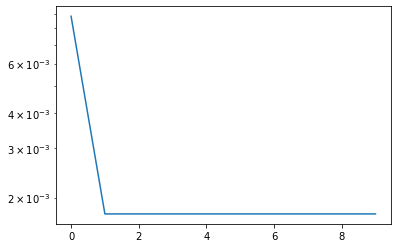

In [70]:
plt.plot(losses)
plt.yscale('log')

In [59]:
def plot_slice(cube):

    cube = cube.data
    
    def plot(i):
        plt.figure(dpi=130)
        plt.imshow(cube[:,:,i], vmin=cube.min(), vmax=cube.max())
        
    return interact(plot, i=(0, cube.shape[2]-1))

In [60]:
co = torch.exp(model['log_CO'])

In [61]:
plot_slice(co)

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_slice.<locals>.plot(i)>

In [257]:
tau.data.min()

tensor(0.0005)

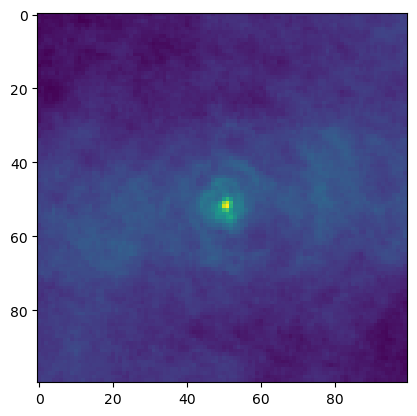

In [258]:
plt.imshow(img.data)

In [260]:
from ipywidgets import interactive

In [330]:
def plot(i):
    plt.imshow(chi.data[:,:,i])

interactive(plot, i=(0,chi.data.shape[2]-1))  

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [259]:
class Data(Dataset):
    def __init__(self, datacube):
        self.datacube = datacube
    
    def __len__(self):
        return self.datacube.img.size

    def __getitem__(self, idx):
        return self.datacube.img[idx]